# Hyperwave: knowledge base embedding

Let's import all the libraries needed for our knowledge base embedding.

In [46]:
import os
import numpy as np
import xarray as xr
import warnings
import torchhd
import torch
from tqdm import tqdm
from urllib3.exceptions import NotOpenSSLWarning


Now, let's configure the runtime environment settings.

In [47]:
# I/O configuration
input_folder = '../data/ncdf'
output_folder = '../data/ncdf'

# Runtime configuration
os.makedirs(output_folder, exist_ok=True)
# np.set_printoptions(suppress=True, precision=8)
# torch.set_printoptions(precision=8, sci_mode=False)

# Ignore annoying urllib3 warnings
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# Load dataset
dataset = xr.load_dataarray(os.path.join(input_folder, "nrm.orx.dataset.nc"))

Other than simulated signals, which are by themselves hypervectors of 20'880 dimensions, we need two kind of additional hypervectors: a random set to label central frequencies, and another one to label radii sizes.

In [48]:
def hdencode(data, in_features, out_features, embed_type="random", vsa="BSC"):
    mapping = {
        "random": torchhd.embeddings.Random,
        "level": torchhd.embeddings.Level,
        "density": torchhd.embeddings.Density
    }
    if embed_type not in mapping:
        raise ValueError(f"Unknown embedding type: {embed_type}")
    embedding = mapping[embed_type](in_features, out_features, vsa=vsa)
    return embedding(data)


In [49]:

no_radii = dataset.radius.size
no_frequencies = dataset.frequency.size
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

frequency_embeddings = hdencode(
    torch.randn(no_frequencies, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

radius_embeddings = hdencode(
    torch.randn(no_radii, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

print(f"Frequencies embeddings: {np.shape(frequency_embeddings)}")
print(f"Radii embeddings: {np.shape(radius_embeddings)}")
print(frequency_embeddings)


Frequencies embeddings: torch.Size([10, 1024])
Radii embeddings: torch.Size([45, 1024])
BSCTensor([[False,  True, False,  ...,  True, False,  True],
           [False, False, False,  ...,  True,  True, False],
           [ True, False, False,  ...,  True, False,  True],
           ...,
           [ True, False,  True,  ...,  True, False, False],
           [ True, False,  True,  ...,  True, False, False],
           [False, False, False,  ...,  True, False, False]])


Now we should embed our simulated signals into a suitable encoding. Since we have used HRR for both central frequencies and radii labels, we will do the same for our signals.

In [50]:
testset_embeddings = torch.tensor(dataset.sel(radius=300).values)

In [51]:
signal_embeddings = xr.apply_ufunc(
    hdencode,
    testset_embeddings,
    # torch.tensor(dataset.values),
    dataset.time.size,
    embedding_size,
    "density",
    vsa_encoding,
    vectorize=True,   # Allows element-wise mapping
)
print(f"Signals embeddings: {np.shape(signal_embeddings)}")
print(signal_embeddings)

Signals embeddings: torch.Size([10, 1024])
BSCTensor([[False,  True,  True,  ..., False,  True, False],
           [False,  True,  True,  ..., False,  True, False],
           [False,  True, False,  ..., False,  True, False],
           ...,
           [ True, False, False,  ..., False,  True, False],
           [ True, False, False,  ..., False,  True, False],
           [False,  True, False,  ..., False,  True, False]])


Now that we have all the embeddings for our dataset, we can incrementally try some experiments. For example, let's create a knowledge base hypervector binding central frequency labels with the corresponding simulated signal:

BSCTensor([[ True, False,  True,  ..., False,  True, False]])


<StemContainer object of 3 artists>

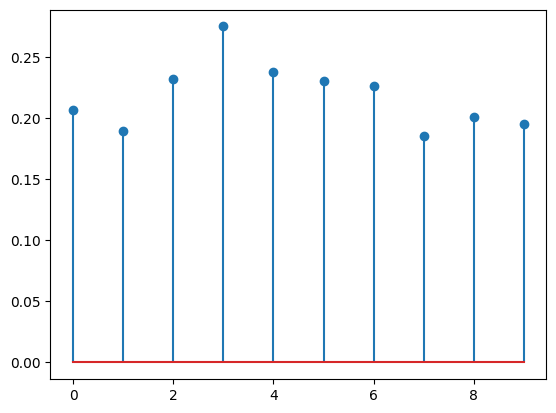

In [52]:
# Create the kbe (knowledge base embedding) for radius=300
# Operations syntax:                   bind := * | bundle := +
# kbe[radius=10] :=
#   [frequency=1MHz] * [signal=(radius=10,frequency=1MHz)    +
#   [frequency=1MHz] * [signal=(radius=10,frequency=2MHz)    +
#   ...
#   [frequency=10MHz] * [signal=(radius=10,frequency=9MHz)]  +
#   [frequency=10MHz] * [signal=(radius=10,frequency=10MHz)]

kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)

# Let's assume we want to know what is the signal like at 4MHz
query_embedding = torchhd.inverse(frequency_embeddings[3])
result = torchhd.bind(kbe, query_embedding)
# Now let's perform a memory cleanup: the result vector should be the
# closest to our simulated signal at frequency=4MHz
print(torchhd.cleanup(result, signal_embeddings))

torchhd.utils.plot_similarity(result, signal_embeddings)


We can see that the result has most similarity with element in position 3, i.e. with the signal having central frequency equal to 4MHz.

In [53]:
no_simulations = 100
correct_validations = 0
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

no_simulations = 10
correct_validations = 0
for i in np.arange(no_simulations):
    frequency_embeddings = hdencode(
        torch.randn(no_frequencies, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding)
    query_index = 0   # Our query will be random_keys_embeddings[0]
    query_embedding = frequency_embeddings[query_index]
    correct_result = signal_embeddings[query_index]
    kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)
    # Let's assume we want to know what is the signal like at 4MHz
    query = torchhd.inverse(query_embedding)
    result = torchhd.bind(kbe, query)
    nearest_match = torchhd.cleanup(result, signal_embeddings)
    # nearest_match = nearest_inner_prod(result, frequency_embeddings)
    if (nearest_match == correct_result).all():
        correct_validations += 1
print(f"Query matching accuracy: {correct_validations / no_simulations * 100}%")

    

Query matching accuracy: 100.0%


<StemContainer object of 3 artists>

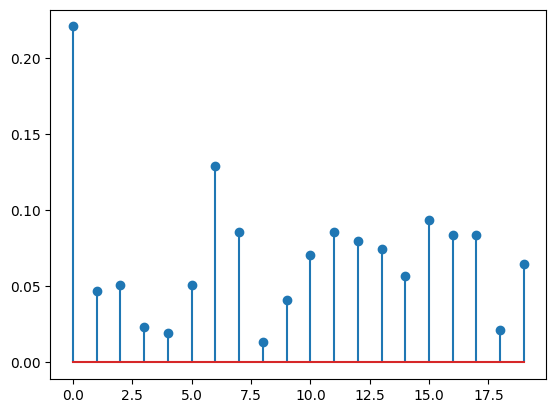

In [54]:
no_keys, no_values = 20, 20
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

random_keys_embeddings = hdencode(
    torch.randn(no_keys, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding
)
random_values_embeddings = hdencode(
    torch.randn(no_values, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding
)
kbe = torchhd.hash_table(random_keys_embeddings, random_values_embeddings)
query = torchhd.inverse(random_keys_embeddings[0])
result = torchhd.bind(kbe, query)
torchhd.utils.plot_similarity(result, random_values_embeddings)

Let's create a small experiment where we embed a knowledge base using random components for both keys and values of our dictionary data structure. In this way, we can compare the baseline accuracy of a random model w.r.t. our signal density projection embedding.

In [55]:
no_simulations = 100
correct_validations = 0
no_keys, no_values = 10, 10
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

for i in np.arange(no_simulations):
    random_keys_embeddings = hdencode(
        torch.randn(no_keys, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding
    )
    random_values_embeddings = hdencode(
        torch.randn(no_values, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding
    )
    query_index = 0   # Our query will be random_keys_embeddings[0]
    query_embedding = random_keys_embeddings[query_index]
    correct_result = random_values_embeddings[query_index]
    kbe = torchhd.hash_table(random_keys_embeddings, random_values_embeddings)
    query = torchhd.inverse(query_embedding)
    result = torchhd.bind(kbe, query)
    nearest_match = torchhd.cleanup(result, random_values_embeddings)
    if (nearest_match == correct_result).all():
        correct_validations += 1
print(f"Query matching accuracy: {correct_validations / no_simulations * 100}%")

Query matching accuracy: 100.0%


The baseline accuracy of value retrieval using as keys signals embeddings or random samples is very similar; basically, we just lose ~1% of accuracy when using signals embeddings, probably because the density encoding still leaves some residuals of time-dependent correlations between datapoints. Now let's try to embed the whole dataset into a single knowledge base.

In [56]:
no_radii = dataset.radius.size
no_frequencies = dataset.frequency.size
embedding_size = 32768
random_embedding_size = 1024
vsa_encoding = "BSC"

In [57]:
frequency_embeddings = hdencode(
    torch.randn(no_frequencies, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

radius_embeddings = hdencode(
    torch.randn(no_radii, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

In [58]:
def embed(dataset, embedding_size, encoding, vsa_format, filename):
    # To iterate the signal dataset more comfortably, we have to permute radii with frequencies
    tensor_dataset =  torch.tensor(dataset.values).permute(1, 0, 2)

    # Using xArray unnamed function, the probability of memory overflow is extremely high.
    # From both spatial and temporal standpoint, it is more efficient to iterate a torch
    # tensor using standard loops. We will use tqdm to show the embedding phase progress.
    frequencies = tensor_dataset.shape[0]
    radii = tensor_dataset.shape[1]
    signal_embeddings = []
    total_iterations = frequencies * radii

    with tqdm(total=total_iterations, desc="Embedding signals", unit="pair") as pbar:
        for frequency in range(frequencies):
            signal_embeddings_by_radius = []
            for radius in range(radii):
                signal = tensor_dataset[frequency, radius, :]
                signal_embedding = hdencode(signal, dataset.time.size, embedding_size, encoding, vsa_format)
                signal_embeddings_by_radius.append(signal_embedding)
                # Progressbar settings: 1Hz refresh rate
                pbar.update(1) # Update frequency
                pbar.set_postfix(freq=frequency+1, radius=radius*10+10) 
            signal_embeddings.append(signal_embeddings_by_radius)

    embeddings = xr.DataArray(
        signal_embeddings,
        dims=('frequency', 'radius', 'dimension'),
        coords={
            'frequency': np.arange(dataset.frequency.size) + 1,
            'radius': np.arange(dataset.radius.size) * 10 + 10,
            'dimension': np.arange(embedding_size) + 1
        }
    )
    embeddings.to_netcdf(os.path.join(output_folder, filename))
    return embeddings

In [59]:
embeddings = embed(
    dataset,
    embedding_size=32768,
    encoding="density",
    vsa_format="BSC",
    filename="nrm.orx.embeddings.nc")

Embedding signals: 100%|██████████| 450/450 [04:41<00:00,  1.60pair/s, freq=10, radius=450]


In [60]:
embeddings = xr.load_dataarray(os.path.join(input_folder, "nrm.orx.embeddings.nc"))
print(embeddings)

<xarray.DataArray (frequency: 10, radius: 45, dimension: 32768)> Size: 15MB
array([[[ True,  True, False, ..., False,  True,  True],
        [False, False,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True,  True, ...,  True, False,  True],
        [False, False, False, ...,  True,  True, False],
        [False, False,  True, ...,  True, False, False]],

       [[ True, False,  True, ..., False,  True,  True],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        ...,
        [False,  True, False, ...,  True, False, False],
        [ True, False,  True, ..., False,  True, False],
        [False, False,  True, ..., False,  True,  True]],

       [[ True,  True, False, ..., False,  True, False],
        [False, False,  True, ...,  True,  True, False],
        [False, False,  True, ..., False, False, False],
        ...,
...
        ...,
        [

In order to retrive and use an embedding, we have to first convert it to a BSCTensor (or whatever torchhd format is preferred). The following is an example of such tensor casting.

In [61]:
test_signal_embedding = embeddings.sel(radius=10, frequency=1)
print(test_signal_embedding)
bsc_test_signal_embedding = torchhd.BSCTensor(test_signal_embedding.values)
print(bsc_test_signal_embedding)

<xarray.DataArray (dimension: 32768)> Size: 33kB
array([ True,  True, False, ..., False,  True,  True])
Coordinates:
  * dimension  (dimension) int32 131kB 1 2 3 4 5 ... 32765 32766 32767 32768
    radius     int32 4B 10
    frequency  int32 4B 1
BSCTensor([1., 1., 0.,  ..., 0., 1., 1.])
